In [1]:
from matplotlib import pyplot as plt

import torch

import pyro
from pyro.infer.mcmc import MCMC
import pyro.distributions as dist
from pyro.infer.mcmc import HMC as HMC_Pyro

from hmc import HMC as HMC_Local
from sghmc import SGHMC as SGHMC_Local

In [2]:
pyro.clear_param_store()

pyro.set_rng_seed(101)

# create some data with 6 observed heads and 4 observed tails
data = torch.ones(10)
data[0:6] = torch.zeros(6)
    
def model(data, alpha0=1., beta0=1.):
    alpha0 = torch.tensor(alpha0)
    beta0 = torch.tensor(beta0)
    
    f = pyro.sample("fairness", dist.Beta(alpha0, beta0))
    
    return pyro.sample("obs", dist.Bernoulli(f), obs=data)

In [3]:
hmc_local = HMC_Local(model, step_size=0.75, num_steps=4)
mcmc_local = MCMC(hmc_local, num_samples=1000)
mcmc_local.run(data)
samples_local = mcmc_local.get_samples()

Sample: 100%|███████████████████████████████████████████████████████████████████████████| 2000/2000 [00:17, 114.06it/s]


In [4]:
BATCH_SIZE = 5

sghmc_local = SGHMC_Local(model, data, batch_size=BATCH_SIZE, step_size=0.1, num_steps=4, with_friction= True, do_mh_correction=False)
#perm = torch.randperm(data.size(0))
#idx = perm[:BATCH_SIZE]
#mini_batch = data[idx]    
sg_mcmc_local = MCMC(sghmc_local, num_samples=1000)
sg_mcmc_local.run(data)
sg_samples_local = sg_mcmc_local.get_samples()

Sample: 100%|███████████████████████████████████████████████████████████████████████████| 2000/2000 [00:16, 121.64it/s]


In [5]:
hmc_pyro = HMC_Pyro(model)
mcmc_pyro = MCMC(hmc_pyro, num_samples=1000)
mcmc_pyro.run(data)
samples_pyro = mcmc_pyro.get_samples()

Sample: 100%|██████████████████████████████████████| 2000/2000 [00:18, 109.61it/s, step size=9.45e-01, acc. prob=0.949]


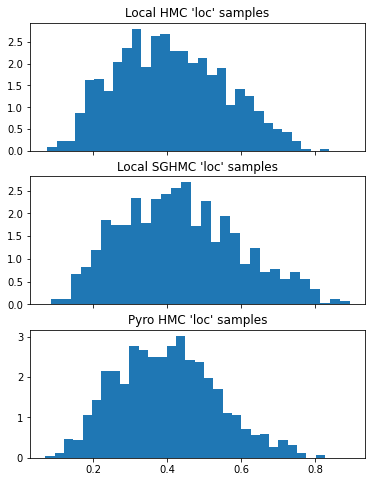

In [6]:
fig, axs = plt.subplots(3, 1, figsize=(6, 8), sharex=True)
with torch.no_grad():
    axs[0].hist(samples_local["fairness"].numpy(), density=True, bins=30)
    axs[0].set(title="Local HMC 'loc' samples")
    axs[1].hist(sg_samples_local["fairness"].numpy(), density=True, bins=30)
    axs[1].set(title="Local SGHMC 'loc' samples")
    axs[2].hist(samples_pyro["fairness"].numpy(), density=True, bins=30)
    axs[2].set(title="Pyro HMC 'loc' samples")
plt.show()
#posterior samples should look like a beta(5, 7) dist